In [ ]:
# To check the model summary like in keras, install torchsummary (Uncomment if using torchsummary)
# %pip install torchsummary

In [1]:
# Hyper-Parameters to control the training Process
# Number of Classes the dataset includes, (for this project, this does not need to be changed)
numOfClasses = 6

# Variable that controls whether to oversample the training dataset or not
# additive: duplicates images to match the number of images in biggest class
# subtract: removes images from biggest class to keep the images in certain range
# mixed: duplicates and removes images to bring the # of images to an average
# None: no balancing is done
oversample = "mixed"

# Variable that controls whether to keep dataset aspect ratio, or squeeze/expand images when resizing
keepSquared = False

# Ratio that splits Dataset into [training, testing] (testing dataset is split into half for validation)
# The values in the list should sum to 1
ratio = [0.70, 0.30]

# Batch size for training when loading images and labels, usually kept to a power of 2 (8, 16, 32 ...)
batchSize = 16

# Which model to use for training.
# Model-Base: Base Model provided by Sidratul
# Model-S: Model created by Saksham
# Model-U: Model created by Umar
# VGG-13: VGG-16 Pretrained Model
# VGG-16: VGG-16 Pretrained Model
# VGG-19: VGG-16 Pretrained Model
# Resnet-18: Resnet-18 Pretrained Model
# Resnet-34: Resnet-34 Pretrained Model
# Resnet-50: Resnet-50 Pretrained Model
# Custom: Uses a custom model, if u haven't built a custom model in the code
#         the default model that is used is Model-Base
modelName = "VGG-16"

# Number of epochs to train the model
epochs = 20

# Loss Function for training [CrossEntropyLoss]
lossFunction = "CrossEntropyLoss"

# Optimizers for training [Adam, SGD]
opt = "Adam"

# Learning Rate for the optimizer
lr = 0.001

# Weight Decay for the optimizer
weight_decay = 0.01

In [2]:
# Paramaters to control training based on device being used
# Number of Workers (on Kaggle with no Acceleration set to 4, if using GPU set to 0)
workers = 2

# If training on GPU set to True, else False (if using CPU or MPS/MAC set to False)
usingGPU = True

# If training on M1 chip / MAC, set to True, else False
usingMAC = False

# Path to the dataset, if the folder `data` contains the folders for the class `0, 1, 2 ...`
# The path would be `....../data`
datasetPath = '/kaggle/input/diabetic-retinopathy-classification-dataset/annotated'

In [3]:
# Import libraries to deal with files
import os

# Import Image from PIL to read Image 
from PIL import Image

# Import libraries for imaging viewing
import numpy as np
import matplotlib.pyplot as plt

import random

# Import Counter for working with labels within Datasets
from collections import Counter

# Import libraries for creating network and handeling data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Import torchvision libraries to manage images
from torchvision import models
import torchvision.transforms as transforms

# Import train_test_split to split Full Dataset
from sklearn.model_selection import train_test_split

# Import tqdm to create a progress bar
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
class MiniDataset(Dataset):
    def __init__(self, images, labels, transform = None):
        
        # Set the list values
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        
        # Read the image (returns a tensor) and get the label
        image = Image.open(self.images[index])
        label = self.labels[index]
        
        # If planning on keeping aspect ratio of retinal scan
        if keepSquared:
            
            # Get the width and height of the image
            width, height = image.size

            # If the width is larger than the height
            if width > height:

                # Calculate the difference, and crop the image so the width is cropped
                difference = width - height
                image = image.crop(((difference//2), 0, width - (difference//2), height))

            # If the height is larger than the width
            elif height > width:

                # Calculate the difference, and crop the image so the height is cropped
                difference = height - width
                image = image.crop((0, (difference//2), width, height - (difference//2)))
        
        # If the dataset included a transform for the image, apply the transform
        if self.transform:
            image = self.transform(image)
        
        # Return the image and the label
        return image, label

In [5]:
class CreateDataset(Dataset):
    def __init__(self, source_dir, splitRatio, transform = None, balanceDataset = "None"):
        
        # Lists to store the important information for a dataset
        images = []
        labels = []
                
        # If the source directory provided isn't a directory, return
        if os.path.isdir(source_dir) == False:
            print(f"{source_dir} not a valid directory")
            return
        
        # If the splitRatio is not a valid percentage, return
        if sum(splitRatio) != 1:
            print(f"{splitRatio} does not add up to 1")
            return
        
        # Get all the folder names of all classes from the source_dir
        inner_dir = os.listdir(source_dir)
        
        # Go through all the folders in source directory
        for i in range(len(inner_dir)):
            
            # Go through all the files within the folder
            for file in os.listdir(os.path.join(source_dir, inner_dir[i])):
                
                # Check if the file extension is a valid image extension
                if (file.lower().endswith(('jpg', 'jpeg', 'png'))):
                    
                    # Add the file path to images list
                    images.append(os.path.join(source_dir, inner_dir[i], file))
                    labels.append(int(inner_dir[i]))
        
        # Split up the full Dataset into Train and Temp sections
        trainImages, tempImages, trainLabels, tempLabels = train_test_split(
            images, labels, test_size = splitRatio[1], random_state = 13, stratify = labels
        )
        
        # Split up the Temp Dataset into Valid and Test sections
        testImages, validImages, testLabels, validLabels = train_test_split(
            tempImages, tempLabels, train_size = 0.5, random_state = 13, stratify = tempLabels
        )
        
        # Default Augmentation that should be applied to all datasets
        defaultAugmentation = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()
        ])
        
        # If we want to balance the dataset using oversampling
        if balanceDataset == "additive":
            
            # Create a dictionary to store all images of labels
            labelsDict = {}
            
            # Fill the dictionary
            for i in range(len(trainLabels)):
                if trainLabels[i] in labelsDict:
                    labelsDict[trainLabels[i]].append(trainImages[i])
                else:
                    labelsDict[trainLabels[i]] = []
                    labelsDict[trainLabels[i]].append(trainImages[i])
            
            # Count how many times each label occurs
            countedLabels = Counter(trainLabels)
            
            # Sort the dictionary by highest occuronce first into a list
            sortedTuples = countedLabels.most_common()
            
            # Get the maximum amount of occurunces
            maximumAmount = sortedTuples[0][1]
            
            # Go through the sortedTuples list
            for i in range(len(sortedTuples)):
                
                # Save the label and it's amounts into a variable
                label = int(sortedTuples[i][0])
                amount = sortedTuples[i][1]
                
                # If the amount isn't the same as maximum amount
                if amount != maximumAmount:
                    
                    # Calculate the difference
                    difference = maximumAmount - amount
                    
                    # Set the base index to iterate from to add image paths
                    base = 0
                    
                    # Set the top index to iterate to
                    top = amount
                    
                    # Set the current index to base
                    index = base
                    
                    # While the difference is greater than 0
                    while difference > 0:
                        
                        # Check if index reached the last value of the list, if so reset it to base
                        if index >= top:
                            index = base
                        
                        # Add the label and the corresponding image to the lists
                        trainLabels.append(label)
                        trainImages.append(labelsDict[label][index])
                        
                        # Increment the index and decrement the difference
                        index = index + 1
                        difference = difference - 1
            
        # If want to balance Dataset by removing images
        elif balanceDataset == "subtract":
            
            # Count how many times each label occurs
            countedLabels = Counter(trainLabels)
            
            # Sort the dictionary by highest occuronce first into a list
            sortedTuples = countedLabels.most_common()
            
            # Get the maximum amount of occurunces
            minimumAmount = sortedTuples[len(sortedTuples)-1][1]
            
            # Calculate the max amount of images allowed per class
            allowedMax = (minimumAmount// 2) + minimumAmount
            
            # Create a dictionary to store how many images we need to remove from each class
            differenceDict = {}
            
            totalDifference = 0
            
            # Fill the dictionary
            for i in range(len(sortedTuples)):
                
                # Save the label and it's amounts into a variable
                label = int(sortedTuples[i][0])
                amount = sortedTuples[i][1]
                
                # Calculate the difference and add it to the dictionary
                difference = amount - allowedMax
                differenceDict[int(sortedTuples[i][0])] = difference
                
                # Add difference to total difference
                totalDifference += difference
            
            # Set the current index,so we always access the latest element
            currentIndex = 0
            
            # Loop until we traverse through the whole list
            while currentIndex < len(trainLabels) - 1:
                
                # If current label has a difference over 0, remove the element
                if differenceDict[trainLabels[currentIndex]] > 0:
                    
                    # Remove image and label
                    trainLabels.pop(currentIndex)
                    trainImages.pop(currentIndex)
                    
                    # Decrement the respective difference and totalDifference
                    differenceDict[trainLabels[currentIndex]] -= 1
                    totalDifference -= 1
                    
                # Else increment the index
                else:
                    currentIndex += 1
                
                # If sufficient images removed, break the while loop
                if totalDifference <= 0:
                    break
        
        # If we want to balance the dataset by increasing certain classes and decreasing others
        elif balanceDataset == "mixed":
            
            # Create a dictionary to store all images of labels
            labelsDict = {}
            
            # Fill the dictionary
            for i in range(len(trainLabels)):
                if trainLabels[i] in labelsDict:
                    labelsDict[trainLabels[i]].append(trainImages[i])
                else:
                    labelsDict[trainLabels[i]] = []
                    labelsDict[trainLabels[i]].append(trainImages[i])
            
            # Count how many times each label occurs
            countedLabels = Counter(trainLabels)
            
            # Sort the dictionary by highest occuronce first into a list
            sortedTuples = countedLabels.most_common()
            
            # calculate how many images we want for each class
            allowed = len(trainLabels) // len(sortedTuples)
            
            # Create a dictionary to store how many images we need to remove/add from each class
            differenceDict = {}
            
            # Total difference to keep track of how many images need to be removed
            totalDifference = 0
            
            # Fill the dictionary
            for i in range(len(sortedTuples)):
                
                # Save the label and it's amounts into a variable
                label = int(sortedTuples[i][0])
                amount = sortedTuples[i][1]
                
                # Calculate the difference and add it to the dictionary
                difference = amount - allowed
                differenceDict[int(sortedTuples[i][0])] = difference
                
                if difference > 0:
                    totalDifference += difference
                
            # Go through the sortedTuples list
            for i in range(len(sortedTuples)):
                
                # Save the label and it's amounts into a variable
                label = int(sortedTuples[i][0])
                amount = sortedTuples[i][1]
                
                # If images need to be added for the label
                if differenceDict[label] < 0:
                    
                    # Set the base index to iterate from to add image paths
                    base = 0
                    
                    # Set the top index to iterate to
                    top = amount
                    
                    # Set the current index to base
                    index = base
                    
                    # While the difference is less than 0
                    while differenceDict[label] < 0:
                        
                        # Check if index reached the last value of the list, if so reset it to base
                        if index >= top:
                            index = base
                        
                        # Add the label and the corresponding image to the lists
                        trainLabels.append(label)
                        trainImages.append(labelsDict[label][index])
                        
                        # Increment the index and decrement the difference
                        index += 1
                        differenceDict[label] += 1
                
                
            # Set the current index,so we always access the latest element
            currentIndex = 0
                
            # Loop until we traverse through the whole list
            while currentIndex < len(trainLabels) - 1:
                                
                # If current label has a difference over 0, remove the element
                if differenceDict[trainLabels[currentIndex]] > 0:
                                        
                    # Remove image and label
                    trainLabels.pop(currentIndex)
                    trainImages.pop(currentIndex)
                    
                    # Decrement the respective difference and totalDifference
                    differenceDict[trainLabels[currentIndex]] -= 1
                    totalDifference -= 1                    
                    
                # Else increment the index
                else:
                    currentIndex += 1
                
                # If sufficient images removed, break the while loop
                if totalDifference <= 0:
                    break
                    
        # Create Three separate Datasets Objects from the Full Dataset
        self.trainDataset = MiniDataset(trainImages, trainLabels, transform)
        self.validDataset = MiniDataset(validImages, validLabels, defaultAugmentation)
        self.testDataset = MiniDataset(testImages, testLabels, defaultAugmentation)

In [6]:
# Function to display the image with it's corresponding label
def showImage(image, label):
    plt.figure()
    plt.imshow(image.permute(1, 2, 0))
    plt.title(str(label))
    plt.xticks([])
    plt.yticks([])

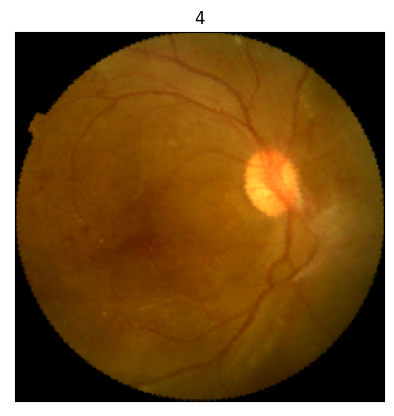

In [7]:
trainAugmentation = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=(0.8,1.2), contrast=(0.8,1.2), saturation=(0.8,1.2), hue=(-0.1,0.1))], p=0.5),
    transforms.ToTensor()
])

# Creating a Dataset
fullDataset = CreateDataset(datasetPath, ratio, transform = trainAugmentation, balanceDataset = oversample)

#Create a DataLoader for each Dataset
trainLoader = DataLoader(fullDataset.trainDataset, batch_size=batchSize, shuffle=True, num_workers=workers, pin_memory=usingGPU)
validLoader = DataLoader(fullDataset.validDataset, batch_size=batchSize, num_workers=workers, pin_memory=usingGPU)
testLoader = DataLoader(fullDataset.testDataset, batch_size=1, pin_memory=usingGPU)

# Display the Image
showImage(fullDataset.trainDataset[0][0], fullDataset.trainDataset[0][1])

In [8]:
print(Counter(fullDataset.trainDataset.labels))
print(Counter(fullDataset.validDataset.labels))
print(Counter(fullDataset.testDataset.labels))

Counter({0: 1849, 4: 1595, 5: 1595, 1: 1595, 3: 1595, 2: 1341})
Counter({0: 940, 2: 671, 5: 172, 4: 137, 1: 95, 3: 36})
Counter({0: 940, 2: 672, 5: 173, 4: 137, 1: 94, 3: 35})


In [9]:
# Base Model provided by Sidratul
class BaseModel(nn.Module):
    def __init__(self, numOfClasses):
        super(BaseModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=9216, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=1024, out_features=numOfClasses, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [10]:
# Model created by Saksham
class SakshamModel(nn.Module):
    def __init__(self, numOfClasses):
        super(SakshamModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),

            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=32768, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(),
            
            nn.Linear(in_features=512, out_features=numOfClasses, bias=True),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [11]:
# Model created by Umar
class UmarModel(nn.Module):
    def __init__(self, numOfClasses):
        super(UmarModel, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,  stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=50176, out_features=1024, bias=True),
            nn.ReLU(),

            nn.Linear(in_features=1024, out_features=numOfClasses, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [12]:
# Custom Model to be overwritten (default provided by Sidratul)
class CustomModel(nn.Module):
    def __init__(self, numOfClasses):
        super(CustomModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=9216, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=1024, out_features=numOfClasses, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [13]:
# Input of size (224, 224, 3) for all models
model = None

if modelName == "Model-Base":
    model = BaseModel(numOfClasses)
    
elif modelName == "Model-S":
    model = SakshamModel(numOfClasses)
    
elif modelName == "Model-U":
    model = UmarModel(numOfClasses)
    
elif modelName == "Custom":
    model = CustomModel(numOfClasses)

elif modelName == "VGG-13":
    model = models.vgg13(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
    
    numOfFeatures = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(numOfFeatures, numOfClasses)
    
elif modelName == "VGG-16":
    model = models.vgg16(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    numOfFeatures = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(numOfFeatures, numOfClasses)
    
elif modelName == "VGG-19":
    model = models.vgg19(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    numOfFeatures = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(numOfFeatures, numOfClasses)

elif modelName == "Resnet-18":
    model = models.resnet18(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    numOfFeatures = model.fc.in_features
    model.fc = nn.Linear(numOfFeatures, numOfClasses)

elif modelName == "Resnet-34":
    model = models.resnet34(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    numOfFeatures = model.fc.in_features
    model.fc = nn.Linear(numOfFeatures, numOfClasses)

elif modelName == "Resnet-50":
    model = models.resnet50(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    numOfFeatures = model.fc.in_features
    model.fc = nn.Linear(numOfFeatures, numOfClasses)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 127MB/s] 


In [14]:
device = None

# Set the device to cuda or mps if available, otherwise keep using cpu
if usingMAC == True:
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

# Set the model to use the cuda or cpu
model = model.to(device)

cuda


In [15]:
# Function to train the model on the Dataset
def train_model(model, loader, criterion, optimizer, epochs):
    
    file = open('/kaggle/working/TrainingStats.txt', 'w')
    file.write("Epoch, Training Accuracy, Training Loss, Validation Accuracy, Validation Loss\n")
    
    # Loop for number of epochs
    for epoch in range(epochs):
        
        classPredictions = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
        totalClassPredictions = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
        
        line = str(epoch + 1) + ", "
        
        # Go through the training and validity datasets and set model state accordingly
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()
                
            # Values to calculate the accuracy while training
            running_loss = 0.0
            running_corrects = 0
            
            # Create the progress bar
            progress_bar = tqdm(enumerate(loader[phase]), total=len(loader[phase]), 
                            desc=f"Epoch ({phase}) [{epoch+1}/{epochs}]")
                        
            # Go through the images and labels in Dataset
            for i, (images, labels) in progress_bar:
                
                # Set the tensors to correspond to correct device
                images = images.to(device)
                labels = labels.to(device)

                # Set the gradients of all optimized tensors to zero
                optimizer.zero_grad()

                # If training, enable the gradients and predict with images and label
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #If in training phase, do backward propogation
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # Calculate each class accuracies if current phase is validation
                    if phase == 'val':
                        for i in range(len(preds)):
                            if labels[i].item() == preds[i].item():
                                classPredictions[labels[i].item()] += 1
                            totalClassPredictions[labels[i].item()] += 1
                
                # Calculate loss and accuracy for current forward pass
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(loader[phase].dataset)
            epoch_acc = running_corrects.double() / len(loader[phase].dataset)
            
            # Print the loss and accuracy
            print('Epoch: {}, {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, phase, epoch_loss, epoch_acc))
                        
            # Print the class Accuracies during validation phase
            if phase == 'val':
                line += str(epoch_acc.item()) + ", " + str(epoch_loss) + "\n"
                
                classAccuracy = {c: classPredictions[c] / totalClassPredictions[c] for c in range(6)}
                print("Class Accuracies: ", {f'Class {c}': f'{classAccuracy[c] * 100:.2f}%' for c in range(6)})
            else:
                line += str(epoch_acc.item()) + ", " + str(epoch_loss) + ", "
        
        file.write(line)

        # For formatting the output
        print("\n")
        
    file.close()
    
    # Return the trained model
    return model

In [16]:
# Runs below code with no_grad() so gradients don't change
@torch.no_grad()

# Function to evaluate the model
def evaluate_model(model, loader):
        
    # Save the current state of the model
    state = model.training
    
    # Set the model to evaluation mode
    model.eval()
    
    # Variables to calculate loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    
    classPredictions = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
    totalClassPredictions = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
    
    # Go through the dataLoader
    for i, (images, labels) in enumerate(loader):
        
        # Convert Image and Label tensors to support the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Get the predictions and loss of the model on the input
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Calculate class accuracies
        for i in range(len(preds)):
            if labels[i].item() == preds[i].item():
                classPredictions[labels[i].item()] += 1
            totalClassPredictions[labels[i].item()] += 1
        
        # Get the loss and accuracy of the current pass
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    # Calculate the total loss and accuracy
    total_loss = running_loss / len(loader.dataset)
    total_acc = running_corrects.double() / len(loader.dataset)
    
    # For good measures, reset the state of the model we saved before evaluation
    model.training = state
    
    # Print the accuracy and Loss
    print('Loss: {:.4f} Acc: {:.4f}'.format(total_loss, total_acc))
    
    # Print class Accuracies
    classAccuracy = {c: classPredictions[c] / totalClassPredictions[c] for c in range(6)}
    print("Class Accuracies: ", {f'Class {c}': f'{classAccuracy[c] * 100:.2f}%' for c in range(6)})

In [17]:
loaders = {
    'train': trainLoader,
    'val': validLoader
}

optimizer = None
criterion = None

# Set the optimizer to Stochastic Gradient Descent or Adam
if opt == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.8, weight_decay=weight_decay)
else:
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Set the loss Function to CrossEntropyLoss (the only supported one right now)
if lossFunction == "CrossEntropyLoss":
    criterion = nn.CrossEntropyLoss()

# Train the Model
trainedModel = train_model(model, loaders, criterion, optimizer, epochs)

Epoch (train) [1/20]:   4%|▎         | 21/599 [00:22<10:10,  1.06s/it] 


KeyboardInterrupt: 

In [ ]:
model = trainedModel

In [ ]:
# Save the Model
torch.save(trainedModel.state_dict(), '/kaggle/working/savedModel.pth')

# Run the model on the test Dataset
evaluate_model(trainedModel, testLoader)

In [ ]:
# Import summary from torchsummary to output the model summary
# from torchsummary import summary

#summary(model, (3, 224, 224))